In [1]:
import sklearn
import shap

# a classic housing price dataset
X, y = shap.datasets.california(n_points=1000)
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

C:\Users\fvl1g23\PycharmProjects\KMeans\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LinearRegression()

In [4]:
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(5))

Model coefficients:

MedInc = 0.42563
HouseAge = 0.01033
AveRooms = -0.1161
AveBedrms = 0.66385
Population = 3e-05
AveOccup = -0.26096
Latitude = -0.46734
Longitude = -0.46272


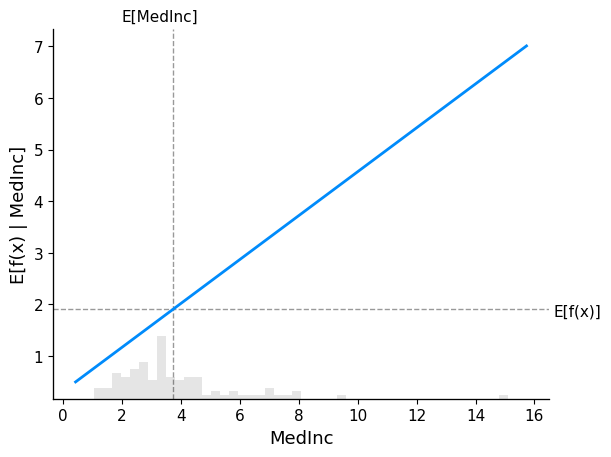

In [5]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

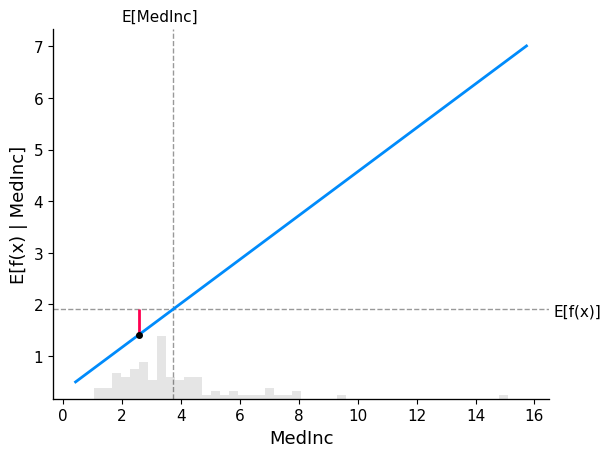

In [6]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

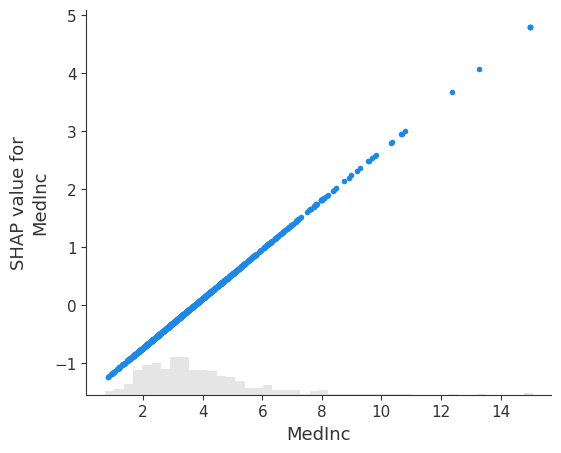

In [7]:
shap.plots.scatter(shap_values[:, "MedInc"])

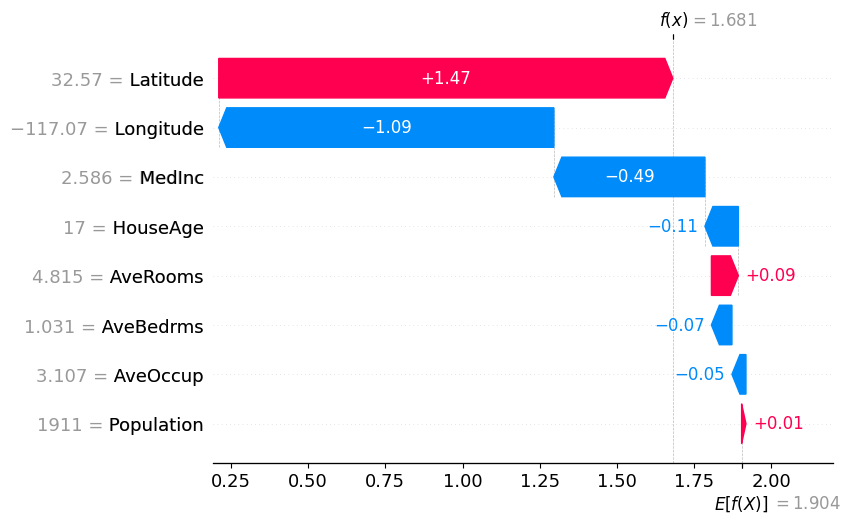

In [8]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

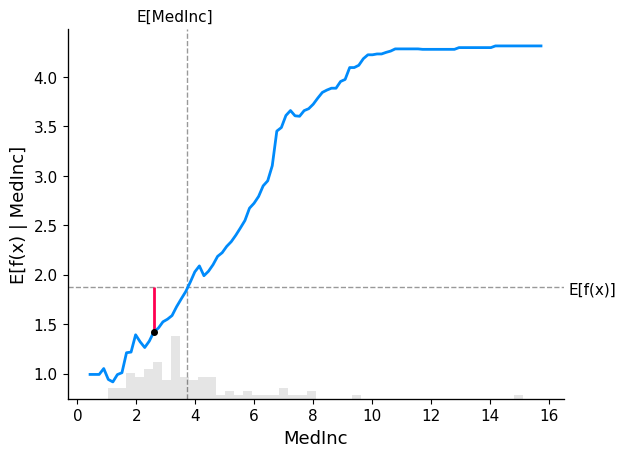

In [10]:
# fit a GAM model to the data
import interpret.glassbox

model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm.predict, X100)
shap_values_ebm = explainer_ebm(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_ebm.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

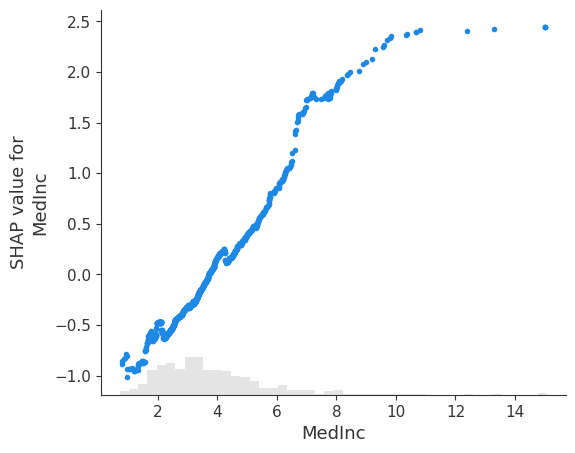

In [11]:
shap.plots.scatter(shap_values_ebm[:, "MedInc"])

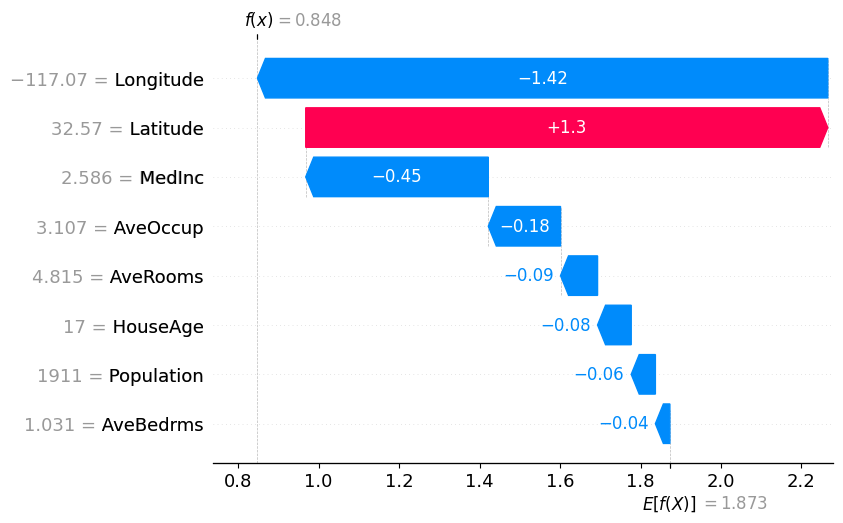

In [12]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[sample_ind])

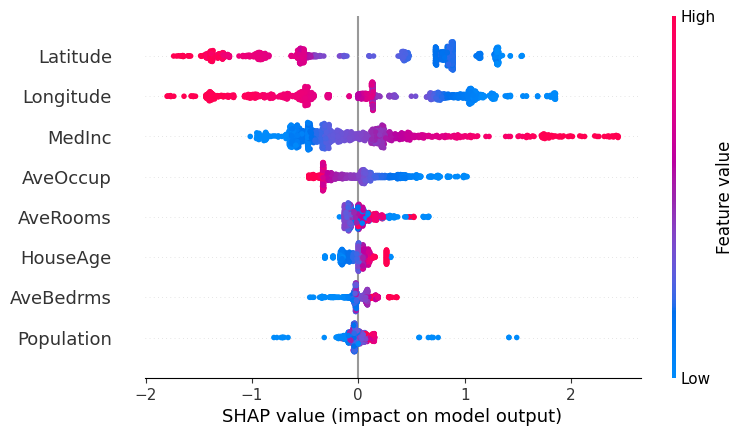

In [13]:
# the beeswarm plot displays SHAP values for each feature across all examples,
# with colors indicating how the SHAP values correlate with feature values
shap.plots.beeswarm(shap_values_ebm)

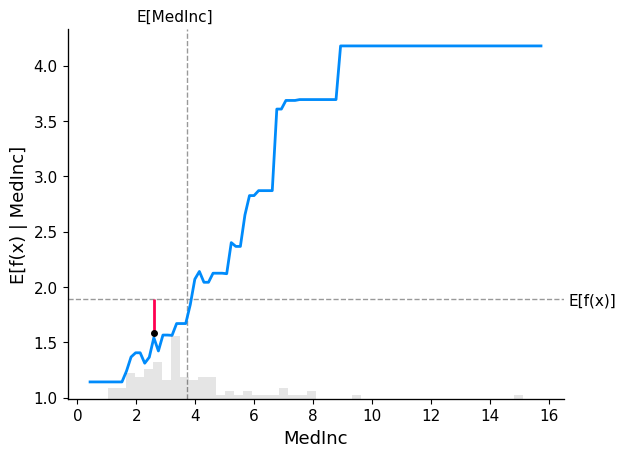

In [14]:
# train XGBoost model
import xgboost

model_xgb = xgboost.XGBRegressor(n_estimators=100, max_depth=2).fit(X, y)

# explain the GAM model with SHAP
explainer_xgb = shap.Explainer(model_xgb, X100)
shap_values_xgb = explainer_xgb(X)

# make a standard partial dependence plot with a single SHAP value overlaid
fig, ax = shap.partial_dependence_plot(
    "MedInc",
    model_xgb.predict,
    X100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_xgb[sample_ind : sample_ind + 1, :],
)

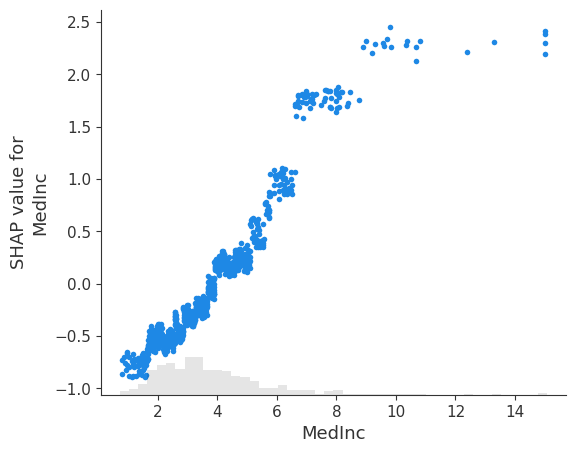

In [15]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"])


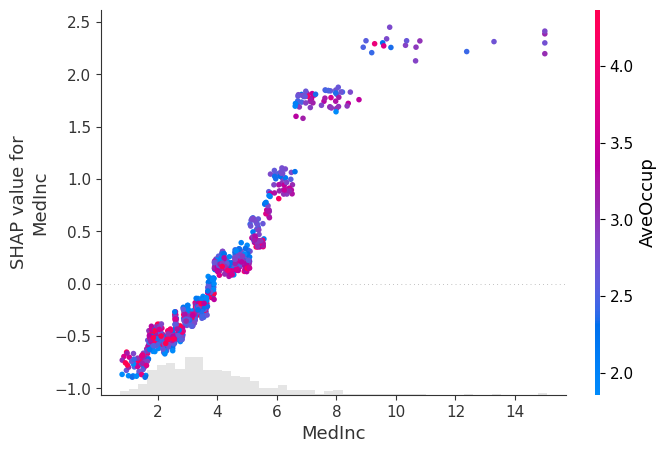

In [16]:
shap.plots.scatter(shap_values_xgb[:, "MedInc"], color=shap_values)


In [17]:
# a classic adult census dataset price dataset
X_adult, y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)


def model_adult_proba(x):
    return model_adult.predict_proba(x)[:, 1]


def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

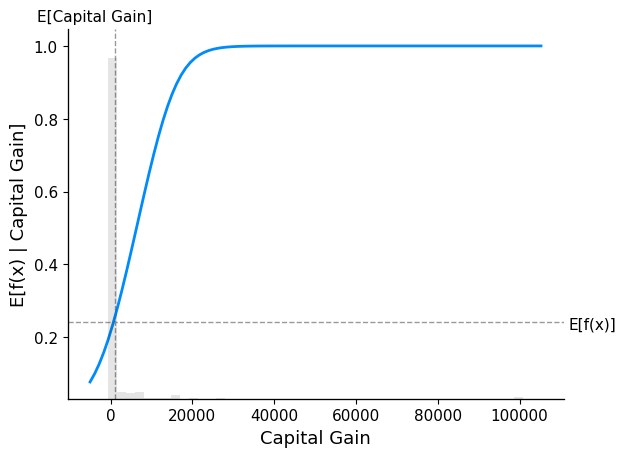

In [18]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

PermutationExplainer explainer: 1001it [00:16, 26.89it/s]                         


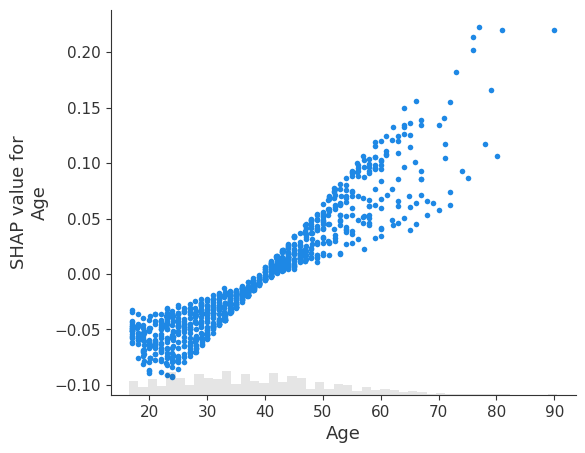

In [19]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])
shap.plots.scatter(shap_values_adult[:, "Age"])

PermutationExplainer explainer: 1001it [00:15, 22.33it/s]                         


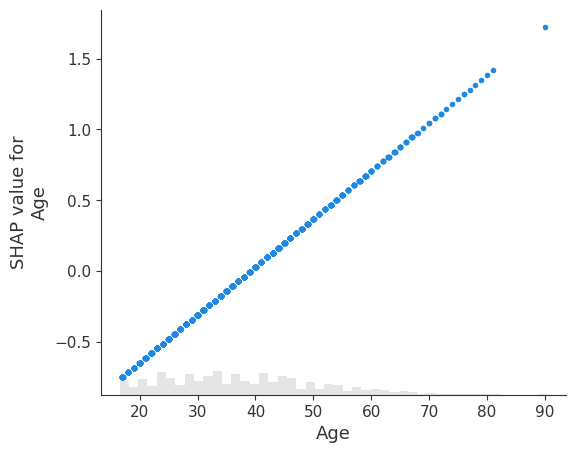

In [20]:
# compute the SHAP values for the linear model
explainer_log_odds = shap.Explainer(model_adult_log_odds, background_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])
shap.plots.scatter(shap_values_adult_log_odds[:, "Age"])

 99%|===================| 32154/32561 [00:11<00:00]       

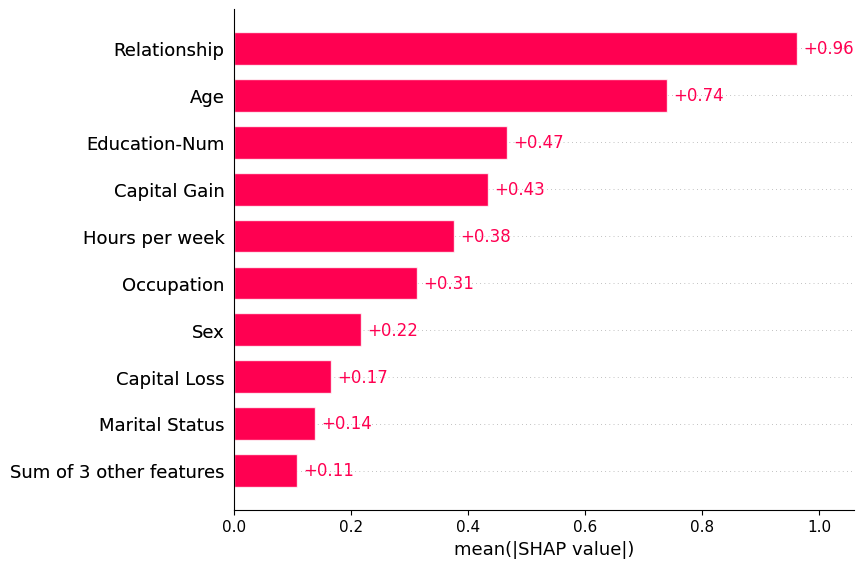

In [22]:
# train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2)
model.set_params(eval_metric="logloss")
model.fit(X_adult, y_adult * 1)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

shap.plots.bar(shap_values)

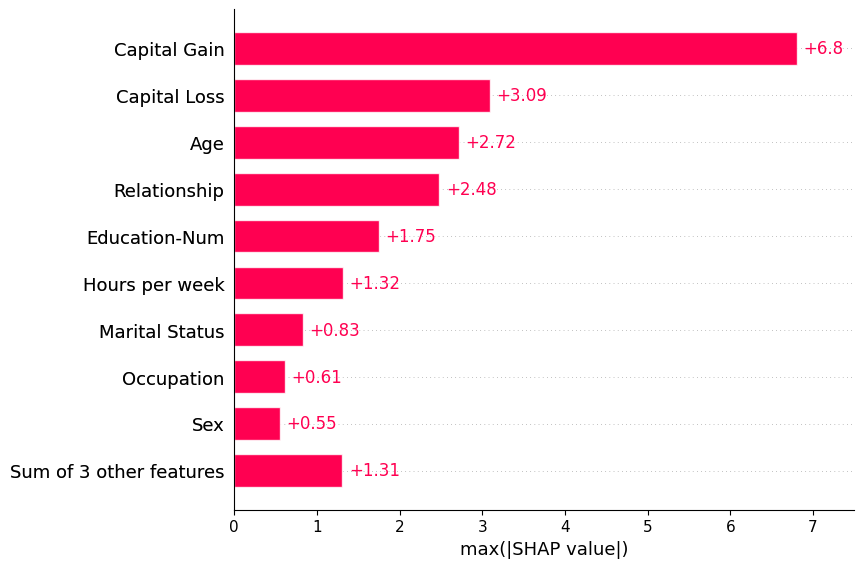

In [24]:
shap.plots.bar(shap_values.abs.max(0))

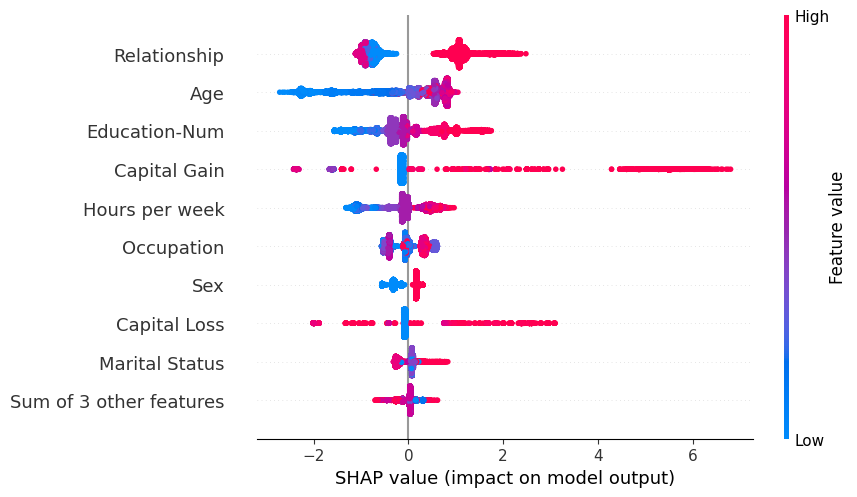

In [25]:
shap.plots.beeswarm(shap_values)

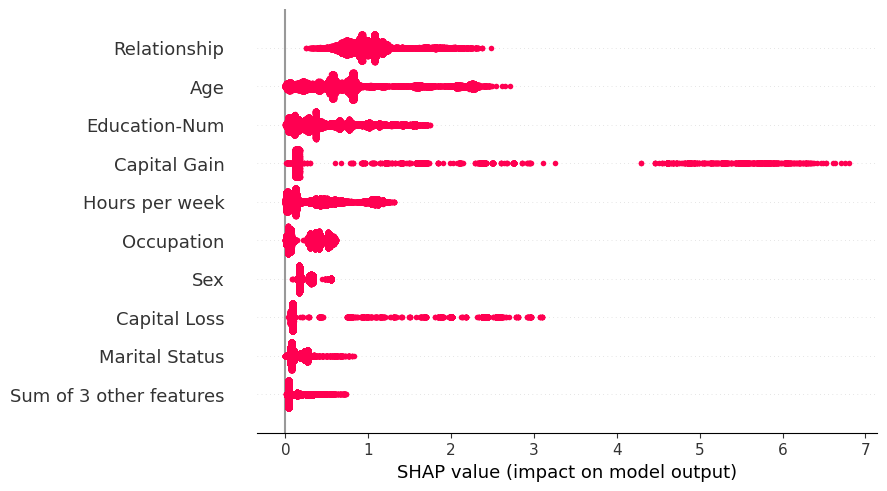

In [26]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

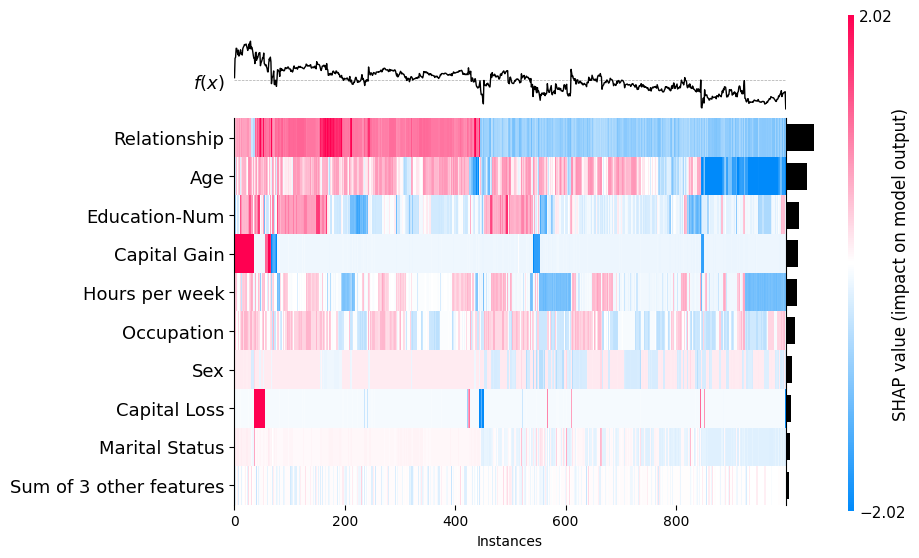

<Axes: xlabel='Instances'>

In [27]:
shap.plots.heatmap(shap_values[:1000])

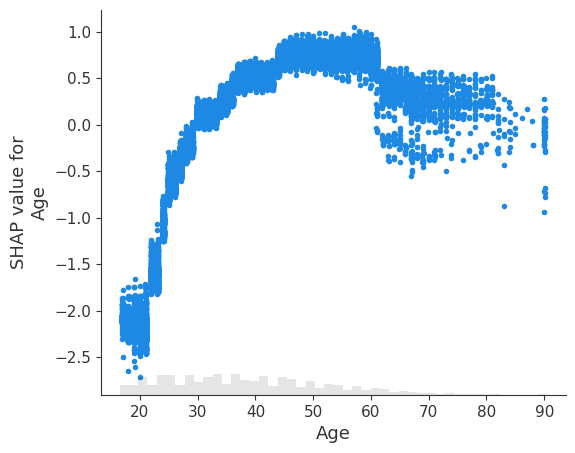

In [28]:
shap.plots.scatter(shap_values[:, "Age"])